# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 


## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


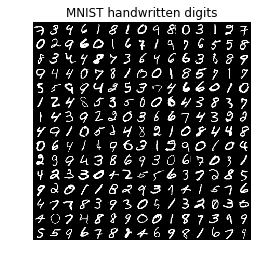

In [2]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [3]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [4]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())


print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [5]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [6]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

ex0_model = tf.train.Saver()

In [7]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [8]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

import os.path
import pickle

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:
            if not os.path.isfile("ex0_model.index"):
                while mnist_data.train.epochs_completed < max_epochs:
                    _train_loss, _train_accuracy = [], []

                    ## Run train op
                    x_batch, y_batch = mnist_data.train.next_batch(batch_size)
                    fetches_train = [train_op, cross_entropy, accuracy]
                    feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                    _, _loss, _acc = sess.run(fetches_train, feed_dict_train)

                    _train_loss.append(_loss)
                    _train_accuracy.append(_acc)


                    ## Compute validation loss and accuracy
                    if mnist_data.train.epochs_completed % 1 == 0 \
                            and mnist_data.train._index_in_epoch <= batch_size:
                        train_loss.append(np.mean(_train_loss))
                        train_accuracy.append(np.mean(_train_accuracy))

                        fetches_valid = [cross_entropy, accuracy]

                        feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                        _loss, _acc = sess.run(fetches_valid, feed_dict_valid)

                        valid_loss.append(_loss)
                        valid_accuracy.append(_acc)
                        
                        print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                            mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
                
                test_epoch = mnist_data.test.epochs_completed
                while mnist_data.test.epochs_completed == test_epoch:
                    x_batch, y_batch = mnist_data.test.next_batch(batch_size)
                    feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
                    _loss, _acc = sess.run(fetches_valid, feed_dict_test)
                    test_loss.append(_loss)
                    test_accuracy.append(_acc)
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                            np.mean(test_loss), np.mean(test_accuracy)))

                ex0_model.save(sess, './ex0_model')
                pickle.dump(train_loss, open("ex0_train_loss.p", "wb" ))
                pickle.dump(train_accuracy, open("ex0_train_accuracy.p", "wb" ))
                pickle.dump(valid_accuracy, open("ex0_valid_accuracy.p", "wb" ))
                pickle.dump(test_loss, open("ex0_test_loss.p", "wb" ))
                pickle.dump(test_accuracy, open("ex0_test_accuracy.p", "wb" ))
            else:
                ex0_model.restore(sess, './ex0_model')
                train_loss = pickle.load(open("ex0_train_loss.p", "rb" ))
                train_accuracy = pickle.load(open("ex0_train_accuracy.p", "rb" ))
                valid_accuracy = pickle.load(open("ex0_valid_accuracy.p", "rb" ))
                test_loss = pickle.load(open("ex0_test_loss.p", "rb" ))
                test_accuracy = pickle.load(open("ex0_test_accuracy.p", "rb" ))
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(np.mean(test_loss), np.mean(test_accuracy)))
                
        except KeyboardInterrupt:
            pass
    

Begin training loop
Test Loss  0.045, Test acc  0.985


(<matplotlib.text.Text at 0x12eae6208>,
 (0.75, 1.03))

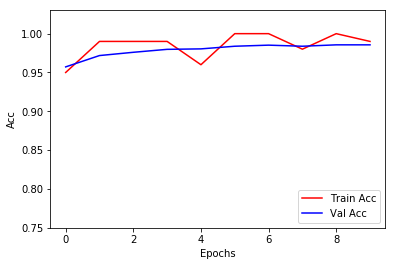

In [9]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

### Answer
### 1.
$$1\times2+2*3 = 8$$
$$1\times2+1\times1+2\times2+2\times2+3\times3 = 20$$
$$1\times2+2\times2+1\times2+2\times3 = 14$$
$$2\times2+2\times1+3\times2+2\times2+3\times3 = 25$$

|    |    |
|----|----|
| 8  | 20 |
| 14 | 25 |


### 2.
Max pooling with a 2x2 on a 2x2 feature results in one number: 25


#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

### <span style="color:blue"> Answer </span>

``` 
Setting the number of filters for layer 2 equal or larger than the dimension of the pool operation in layer 1 result in the desired dimension (1,1,?) as well as setting the new pool size of hidden layer 2 equal to the number of filters.
We set the filter_2 number to the smallest possible value, 14. This means that pool_size_2 is (14,14).
See below for full code.
```


``` 
Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
x_pl 		 (?, 28, 28, 1)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  6180 trainable parameters.
Forward pass successful!
```


In [ ]:
import os
os._exit(00) # force restart of kernel due to strange behaviour if previous model is present

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


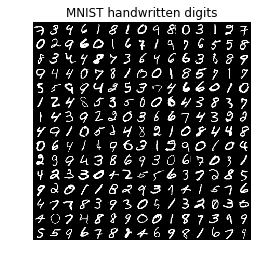

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
x_pl 		 (?, 28, 28, 1)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  6180 trainable parameters.
Forward pass successful!


In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (5,5)
pool_size_2 = (filters_2,filters_2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    #x = flatten(x)
    #print('Flatten \t', x.get_shape())

    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')



gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

ex2_model = tf.train.Saver()

    
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

In [2]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

import os.path
import pickle

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:
            if not os.path.isfile("ex2_model.index"):
                while mnist_data.train.epochs_completed < max_epochs:
                    _train_loss, _train_accuracy = [], []

                    ## Run train op
                    x_batch, y_batch = mnist_data.train.next_batch(batch_size)
                    fetches_train = [train_op, cross_entropy, accuracy]
                    feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                    _, _loss, _acc = sess.run(fetches_train, feed_dict_train)

                    _train_loss.append(_loss)
                    _train_accuracy.append(_acc)


                    ## Compute validation loss and accuracy
                    if mnist_data.train.epochs_completed % 1 == 0 \
                            and mnist_data.train._index_in_epoch <= batch_size:
                        train_loss.append(np.mean(_train_loss))
                        train_accuracy.append(np.mean(_train_accuracy))

                        fetches_valid = [cross_entropy, accuracy]

                        feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                        _loss, _acc = sess.run(fetches_valid, feed_dict_valid)

                        valid_loss.append(_loss)
                        valid_accuracy.append(_acc)
                        
                        print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                            mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
                
                test_epoch = mnist_data.test.epochs_completed
                while mnist_data.test.epochs_completed == test_epoch:
                    x_batch, y_batch = mnist_data.test.next_batch(batch_size)
                    feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
                    _loss, _acc = sess.run(fetches_valid, feed_dict_test)
                    test_loss.append(_loss)
                    test_accuracy.append(_acc)
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                            np.mean(test_loss), np.mean(test_accuracy)))

                ex2_model.save(sess, './ex2_model')
                pickle.dump(train_loss, open("ex2_train_loss.p", "wb" ))
                pickle.dump(train_accuracy, open("ex2_train_accuracy.p", "wb" ))
                pickle.dump(valid_accuracy, open("ex2_valid_accuracy.p", "wb" ))
                pickle.dump(test_loss, open("ex2_test_loss.p", "wb" ))
                pickle.dump(test_accuracy, open("ex2_test_accuracy.p", "wb" ))
            else:
                ex2_model.restore(sess, './ex2_model')
                train_loss = pickle.load(open("ex2_train_loss.p", "rb" ))
                train_accuracy = pickle.load(open("ex2_train_accuracy.p", "rb" ))
                valid_accuracy = pickle.load(open("ex2_valid_accuracy.p", "rb" ))
                test_loss = pickle.load(open("ex2_test_loss.p", "rb" ))
                test_accuracy = pickle.load(open("ex2_test_accuracy.p", "rb" ))
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(np.mean(test_loss), np.mean(test_accuracy)))
                
        except KeyboardInterrupt:
            pass
    

Begin training loop
Test Loss  0.097, Test acc  0.970


(<matplotlib.text.Text at 0x12e4b0780>,
 (0.75, 1.03))

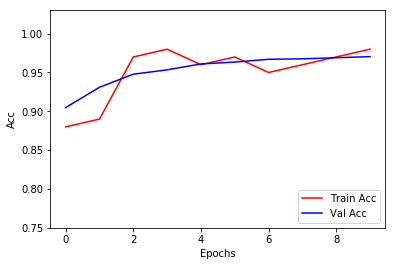

In [3]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___

### <span style="color:blue"> Answer </span>
1. A satisfactory paramter set have been found:
    * Number of layers: input, 2 hidden layers and output: 4 layers. 
    * Number of filter: 16 filters in first hidden layer and 14 filters in second layer.
    * Kernel size: reduced in second layer to limit the number of total model parameters.
    * Pooling size: size equal to number of filters

1. This network, which use the described parameters, result in a validation accuracy of 95%.


```
Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
x_pl 		 (?, 28, 28, 1)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  2596 trainable parameters.
Forward pass successful!
```


In [ ]:
import os
os._exit(00)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


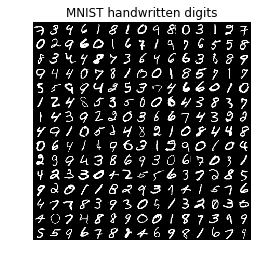

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
x_pl 		 (?, 28, 28, 1)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  2596 trainable parameters.
Forward pass successful!


In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2,filters_2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    #x = flatten(x)
    #print('Flatten \t', x.get_shape())

    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')



gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

ex3_model = tf.train.Saver()

    
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

In [2]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

import os.path
import pickle

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:
            if not os.path.isfile("ex3_model.index"):
                while mnist_data.train.epochs_completed < max_epochs:
                    _train_loss, _train_accuracy = [], []

                    ## Run train op
                    x_batch, y_batch = mnist_data.train.next_batch(batch_size)
                    fetches_train = [train_op, cross_entropy, accuracy]
                    feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                    _, _loss, _acc = sess.run(fetches_train, feed_dict_train)

                    _train_loss.append(_loss)
                    _train_accuracy.append(_acc)


                    ## Compute validation loss and accuracy
                    if mnist_data.train.epochs_completed % 1 == 0 \
                            and mnist_data.train._index_in_epoch <= batch_size:
                        train_loss.append(np.mean(_train_loss))
                        train_accuracy.append(np.mean(_train_accuracy))

                        fetches_valid = [cross_entropy, accuracy]

                        feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                        _loss, _acc = sess.run(fetches_valid, feed_dict_valid)

                        valid_loss.append(_loss)
                        valid_accuracy.append(_acc)
                        
                        print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                            mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
                
                test_epoch = mnist_data.test.epochs_completed
                while mnist_data.test.epochs_completed == test_epoch:
                    x_batch, y_batch = mnist_data.test.next_batch(batch_size)
                    feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
                    _loss, _acc = sess.run(fetches_valid, feed_dict_test)
                    test_loss.append(_loss)
                    test_accuracy.append(_acc)
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                            np.mean(test_loss), np.mean(test_accuracy)))

                ex3_model.save(sess, './ex3_model')
                pickle.dump(train_loss, open("ex3_train_loss.p", "wb" ))
                pickle.dump(train_accuracy, open("ex3_train_accuracy.p", "wb" ))
                pickle.dump(valid_accuracy, open("ex3_valid_accuracy.p", "wb" ))
                pickle.dump(test_loss, open("ex3_test_loss.p", "wb" ))
                pickle.dump(test_accuracy, open("ex3_test_accuracy.p", "wb" ))
            else:
                ex3_model.restore(sess, './ex3_model')
                train_loss = pickle.load(open("ex3_train_loss.p", "rb" ))
                train_accuracy = pickle.load(open("ex3_train_accuracy.p", "rb" ))
                valid_accuracy = pickle.load(open("ex3_valid_accuracy.p", "rb" ))
                test_loss = pickle.load(open("ex3_test_loss.p", "rb" ))
                test_accuracy = pickle.load(open("ex3_test_accuracy.p", "rb" ))
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(np.mean(test_loss), np.mean(test_accuracy)))
                
        except KeyboardInterrupt:
            pass
    

Begin training loop
Test Loss  0.157, Test acc  0.950


(<matplotlib.text.Text at 0x129be9c88>,
 (0.75, 1.03))

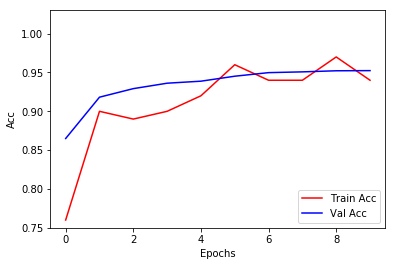

In [3]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

### <span style="color:blue">Answer</span>
A dense network with 2395 parameters achieves an accuracy of 44%. As shown earlier, the convolutional network with roughly the same number of parameters, 2596, result in an accuracy of 95%. In Week 1 we where able to achieve 97% using a dense network with an order-of-magnitude more parameters, but since the training time using the backpropagation algorithm is in $O(W)$ Big-O time complexity (where $W$ is number of parameters, source: https://www.cs.toronto.edu/~graves/preprint.pdf page 18), it can be concluded that using a ConvNet is much faster than using a dense network. In other words, a good accuracy is achievable with a ConvNet using about a tenth of the complexity required for a dense network.
See code below for a dense network.

In [ ]:
import os
os._exit(00)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (784,)
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


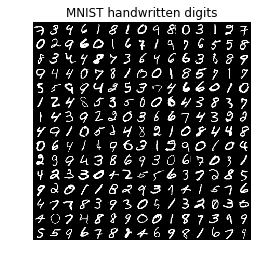

Model consits of  2395 trainable parameters.
Forward pass successful!


In [1]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 

import tensorflow as tf
import numpy as np
import utils
%matplotlib inline
import matplotlib.pyplot as plt

# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)


tf.reset_default_graph()

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

with tf.variable_scope('layer1'): 
    W_1 = tf.get_variable('W', [784, 3], 
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [3], 
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        l_1 = tf.matmul(x_pl, W_1) + b_1
        l_1 = tf.nn.relu(l_1)

with tf.variable_scope('layer2'): 
    W_2 = tf.get_variable('W', [3, num_classes],  
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes], 
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        l_2 = tf.matmul(l_1, W_2) + b_2
        l_2 = tf.nn.relu(l_2)

y = tf.nn.softmax(l_2)

print('Model consits of ', utils.num_params(), 'trainable parameters.')


with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)
    
with tf.variable_scope('trainOP'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

ex4_model = tf.train.Saver()

batch_size = 256

#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

In [2]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

import os.path
import pickle

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:
            if not os.path.isfile("ex4_model.index"):
                while mnist_data.train.epochs_completed < max_epochs:
                    _train_loss, _train_accuracy = [], []

                    ## Run train op
                    x_batch, y_batch = mnist_data.train.next_batch(batch_size)
                    fetches_train = [train_op, cross_entropy, accuracy]
                    feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                    _, _loss, _acc = sess.run(fetches_train, feed_dict_train)

                    _train_loss.append(_loss)
                    _train_accuracy.append(_acc)


                    ## Compute validation loss and accuracy
                    if mnist_data.train.epochs_completed % 1 == 0 \
                            and mnist_data.train._index_in_epoch <= batch_size:
                        train_loss.append(np.mean(_train_loss))
                        train_accuracy.append(np.mean(_train_accuracy))

                        fetches_valid = [cross_entropy, accuracy]

                        feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                        _loss, _acc = sess.run(fetches_valid, feed_dict_valid)

                        valid_loss.append(_loss)
                        valid_accuracy.append(_acc)
                        
                        print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                            mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
                
                test_epoch = mnist_data.test.epochs_completed
                while mnist_data.test.epochs_completed == test_epoch:
                    x_batch, y_batch = mnist_data.test.next_batch(batch_size)
                    feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
                    _loss, _acc = sess.run(fetches_valid, feed_dict_test)
                    test_loss.append(_loss)
                    test_accuracy.append(_acc)
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                            np.mean(test_loss), np.mean(test_accuracy)))

                ex4_model.save(sess, './ex4_model')
                pickle.dump(train_loss, open("ex4_train_loss.p", "wb" ))
                pickle.dump(train_accuracy, open("ex4_train_accuracy.p", "wb" ))
                pickle.dump(valid_accuracy, open("ex4_valid_accuracy.p", "wb" ))
                pickle.dump(test_loss, open("ex4_test_loss.p", "wb" ))
                pickle.dump(test_accuracy, open("ex4_test_accuracy.p", "wb" ))
            else:
                ex4_model.restore(sess, './ex4_model')
                train_loss = pickle.load(open("ex4_train_loss.p", "rb" ))
                train_accuracy = pickle.load(open("ex4_train_accuracy.p", "rb" ))
                valid_accuracy = pickle.load(open("ex4_valid_accuracy.p", "rb" ))
                test_loss = pickle.load(open("ex4_test_loss.p", "rb" ))
                test_accuracy = pickle.load(open("ex4_test_accuracy.p", "rb" ))
                print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(np.mean(test_loss), np.mean(test_accuracy)))
                
        except KeyboardInterrupt:
            pass
    

Begin training loop
Test Loss  1.472, Test acc  0.440


(<matplotlib.text.Text at 0x1042c3278>, <matplotlib.text.Text at 0x121591a58>)

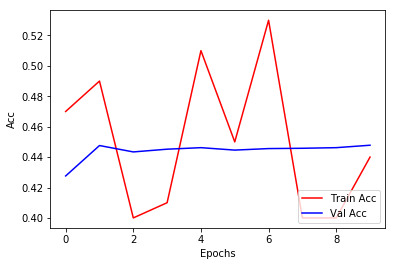

In [3]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc')

# Book Exercise, Chapter 1
## Problem
An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, $x$, we update our weights and biases according to the rules $w_k\rightarrow w'_k=w_k-\eta\partial C_x/\partial w_k$ and $b_l\rightarrow b'_l=b_l-\eta\partial C_x/\partial b_l$. Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20.


## Answer
**TL;DR**:

**Advantage** of online learning: a batch size of 1 means no need to tune a batch-size parameter.

**Disadvantage** of online learning: no way to parallelize computations.


There's a good hint in the jupyter notebook on why it is beneficial to use mini-batches:

>In the last notebook we used the entire dataset to compute every parameter update. For large datasets this is very costly and inefficient. Instead we can compute the gradient on only a small subset of the data, a mini-batches, and use it to update the parameters.

Note that gradient descent with a mini-batch size of 1 is also called *true* gradient descent.
In trying to understand why mini-batching works, I found the following quote:

>["mini-batch"] can perform significantly better than true stochastic gradient descent because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.

*Source: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Iterative_method*

Stanford Professor Andrew Ng agrees on the benefits of vectorization, saying that vectorization allows for parallelization of the gradient descent computations, as described in his Coursera video on mini-batching (from 4 min 25 sec) *https://www.coursera.org/learn/machine-learning/lecture/9zJUs/mini-batch-gradient-descent*
Andrew Ng also describes a disadvantage of mini-batching, namely that you introduce *yet another parameter* that needs tuning.
